In [1]:
import geopandas as gpd
from osgeo import ogr
import pandas as pd
import tifffile as tiff #needed for the tif data for perry county
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from math import sin, cos, sqrt, atan2, radians
import sys
from shapely.geometry import Polygon, box, Point, LineString, MultiLineString
import pickle
import gurobipy as gp
from gurobipy import GRB
import tifffile as tiff #needed for the tif data for perry county
import xlwt
from xlwt import Workbook
from shapely.ops import snap, split, nearest_points
#from shapely.geometry import MultiPoint, LineString
#from dbfread import DBF
import osmnx as ox
import networkx as nx
import math
import gurobipy as gp
from gurobipy import GRB
import os
import csv

In [2]:
# calculate distance
def haversinedist(lat1, lon1, lat2, lon2):
    R = 6373.0
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    return distance * 1000 #unit in km

In [3]:
# read data
def readClusterFile(fileID):
    file = np.genfromtxt(fileID, delimiter=",", skip_header = 1)
    file = file[:,1:]
    return file
clusterfile = 'Centralized_elevcluster' + str(1) + '.csv'

In [4]:
building_coords = readClusterFile(clusterfile)

In [5]:
#convert data to dataframe
df = pd.DataFrame(building_coords,
                  columns = ['longitude','latitude','elevation'])

In [6]:
#check # of null
df.isnull().sum(axis=0).sort_values(ascending=False)/float(len(building_coords))

longitude    0.0
latitude     0.0
elevation    0.0
dtype: float64

In [7]:
# cluster, n_clusters is from table 2 in paper draft, using ward-tree
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=100, affinity='euclidean', linkage='ward')
cluster.fit_predict(building_coords[:,1:2])

array([46, 94, 60, ..., 92, 15, 64])

In [8]:
# add cluster to dataframe
df['cluster.labels_'] = cluster.labels_.tolist()

In [9]:
# select highest and lowest nodes in cluster
tank = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmax()].reset_index(drop=True)
trem = df.loc[df.groupby(['cluster.labels_'])['elevation'].idxmin()].reset_index(drop=True)

In [10]:
# creat MST

graph = []
mstree = []
def createMSTnx(dataframe):
    #only takes longitude and latitude from the cluster data, note we also have elevation and stuff there too
    #coordinates = twoDcluster
    for k in range(10):
        cluster = dataframe[dataframe['cluster.labels_'] == k]
        cluster = cluster[['longitude','latitude']]
        latlon = cluster.to_numpy()
        nrows, ncols = latlon.shape
        #creates graph
        graph.append(nx.Graph())
        weights = []
        #distance in km as weight between each point in the graph
        for i in range(nrows):
            graph[k].add_node(i,pos=(latlon[i,0],latlon[i,1]))
            for j in range(i+1,nrows):
                dist = haversinedist(latlon[i,1], latlon[i,0], latlon[j,1], latlon[j,0])
                weights.append(dist)
                graph[k].add_edge(i,j, weight = dist)
        #creates MST
        mstree.append(nx.minimum_spanning_tree(graph[k]))
    return mstree, graph

In [11]:
createMSTnx(df)

([<networkx.classes.graph.Graph at 0x7fd758d2fb50>,
  <networkx.classes.graph.Graph at 0x7fd758197460>])

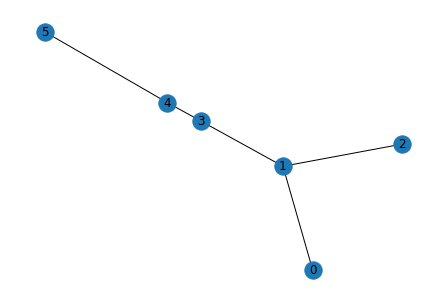

In [12]:
# draw a simulation of mst graph

nx.draw(mstree[9],with_labels = True)

In [13]:
m = gp.Model('pipe and pump distribution')
m.Params.timeLimit = 12000

Set parameter Username
Academic license - for non-commercial use only - expires 2022-09-18
Set parameter TimeLimit to value 12000


In [14]:
# pipe parameters
pipesize = [0.05, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6] #m
pipesize_str, pipecost = gp.multidict({'0.05': 8.7, '0.06': 9.5, '0.08': 11, \
                                                   '0.1': 12.6, '0.15': 43.5,'0.2': 141, '0.25': 151, '0.3': 161, '0.35':230, '0.4': 246, '0.45':262, 
                                                   '0.5':292, '0.6':315})

In [15]:
# find label of tank node in cluster
tank_lon = str(tank[tank['cluster.labels_'] == 9][['longitude']].iat[0,0])
tank_lat = str(tank[tank['cluster.labels_'] == 9][['latitude']].iat[0,0])
for i in mstree[9].nodes():
    if str(mstree[9].nodes[i]['pos'][0]) == tank_lon and str(mstree[9].nodes[i]['pos'][1]) == tank_lat:
        tank_node = i

In [16]:
#create flow direction dict
links = list(mstree[9].edges)
flow_dir = {}
for i,j in links:
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node i is nearer to tank
        flow_dir[i,j]=(i,j)
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node j is nearer to tank
        flow_dir[i,j]=(j,i) 

In [17]:
innode = {}
outnode = {}
for i,j in links:
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node j is nearer to tank
        innode.setdefault(i, [])
        innode[i].append(j)
        outnode.setdefault(j, [])
        outnode[j].append(i)
    else:
        # if node i is nearer to tank
        innode.setdefault(j, [])
        innode[j].append(i)
        outnode.setdefault(i, [])
        outnode[i].append(j)
for i in mstree[9].nodes():
    innode.setdefault(i,[])
    outnode.setdefault(i, [])

In [18]:
# pipe flow
pipe_flow = {}
for i,j in links:
    start = flow_dir[i,j][0]
    end = flow_dir[i,j][1]
    pipe_flow[i,j] = 1.095E-5*(len(outnode[end])+1) #250gpd to m3/s

In [19]:
# Edge list
edge_list = {}
for i,j in links:
        edge_list[i,j] =[pipe_flow[i,j],mstree[9][i][j]["weight"]]

In [20]:
mstree[9][3][4]["weight"]

1408.2637063477366

In [21]:
edge_list

{(0, 1): [1.095e-05, 64.2426819389007],
 (1, 2): [1.095e-05, 51.495293154562916],
 (1, 3): [3.285e-05, 139.08777358090938],
 (3, 4): [2.19e-05, 1408.2637063477366],
 (4, 5): [1.095e-05, 30.897175888775504]}

In [22]:
poss_loss = {}
for i, j in links:
    poss_loss[i,j]= 10700*(edge_list[i,j][0]/140)**1.852*(1/0.05**4.8704)*mstree[9][i][j]["weight"]


Hmax = max(poss_loss.values())
Hmax = 0.1

In [23]:
poss_loss

{(0, 1): 0.10282761393865626,
 (1, 2): 0.08242398922870892,
 (1, 3): 1.7029567340084986,
 (3, 4): 8.13724953182342,
 (4, 5): 0.04945439353088333}

In [24]:
#node elevation excavation in meters
#upper bound is arbritrary maximum depth assuming 1 foot or 0.3048 meters of cover beneath the surface is needed for the pipes
#a lower bound variable is created but not used. In future models might need to implement that depending on the site (digging too deep for excavation is not feasible for many projects)
cluster9 = df[df['cluster.labels_'] == 9]
cluster9_elv = cluster9[['elevation']]
elevation_ub = dict()
elevation_lb = dict()
for i in range(mstree[9].number_of_nodes()):
    elevation_ub[i] = cluster9_elv.iloc[[i]] - 0.3048
    elevation_lb[i] = cluster9_elv.iloc[[i]] - 30

In [25]:
# binary variable indicating if at link ij pipe of diameter k is implemented
d = m.addVars(mstree[9].edges(), pipesize, vtype = GRB.BINARY, name = "diameter")
#continuous variable representing the hydro loss in link ij.
HL = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro loss")
# hydro gradient
J = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "hydro gradient")
# binary variable indicating if at link ij the pump of type m is implemented.
p = m.addVars(mstree[9].edges(), vtype = GRB.BINARY, name = "PUMP")
#continuous variable representing the pressure injected by the pump at link ij.
pr = m.addVars(mstree[9].edges(),lb = 0, vtype = GRB.CONTINUOUS, name = "PRESSURE BY PUMP")
#pipe elevations at node i 
e = m.addVars(mstree[9].nodes(), vtype = GRB.CONTINUOUS, name = 'In Node Elevation')
#continuous variable representing the head pressure at node i
P = m.addVars(mstree[9].nodes(),lb = 0, vtype = GRB.CONTINUOUS, name = "HEAD PRESSURE")

In [26]:
for i,j in links:
#Hazen Williams equation, A = 10700, C=140, P472
    m.addConstr(J[i,j] == 
                10700*(edge_list[i,j][0]/140)**1.852*gp.quicksum(d[i,j,k]/(k**4.8704) for k in pipesize)
               , "Hydro loss")
    m.addConstr(HL[i,j] == J[i,j]*mstree[9][i][j]["weight"])
    m.addConstr(HL[i,j] >= 0)
    m.addConstr(HL[i,j] <= Hmax)
#only one pipe per edge
    m.addConstr((d.sum(i, j, '*') == 1.0), "single size chosen")
#injected pressure pr[i,j] must be less than a huge number.
    m.addConstr(pr[i,j]<=p[i,j]*10**6)
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) < len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node i is nearer to tank        
        m.addConstr(P[j] == P[i] -HL[i,j] + e[i] - e[j] + pr[i,j], "Energy balance")
    if len(nx.shortest_path(mstree[9],source=tank_node, target=i)) > len(nx.shortest_path(mstree[9],source=tank_node, target=j)):
        # if node j is nearer to tank        
        m.addConstr(P[i] == P[j] -HL[i,j] + e[j] - e[i] + pr[i,j], "Energy balance")
# Velocity must be between 0.6 and 3 m/s to 30
    m.addConstr((
    edge_list[i,j][0] <= ((3.14/8)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 10), "Velocity Max Constr"+ str([i,j]))
    #m.addConstr((
    #edge_list[i,j][0] >= ((3.14/8)*gp.quicksum(d[i,j,k]*k**2 for k in pipesize)) * 0.6), "Velocity Min Constr" + str([i,j]))  
    

In [27]:
for i in mstree[9].nodes():
#pipe elevation must be betwenn lb and ub
    m.addConstr(e[i] >= float(str(elevation_lb[i])[20:]), "PIPE ELV LB")
    m.addConstr(e[i] <= float(str(elevation_ub[i])[20:]), "PIPE ELV UB")
    
    m.addConstr(P[i] >= 68.9476, "Min head pressure") #10 psi, covert it to kpa
    m.addConstr(P[i] <= 551.581, "Max head pressure") #80 psi, covert it to kpa  

In [28]:
excavation = 25
bedding_cost_sq_ft = 6
capital_cost_pump_station = 166000
ps_flow_cost = 0.19
ps_OM_cost = 175950

In [29]:
# pipe cost 
obj1 = gp.quicksum(mstree[9][i][j]["weight"] * gp.quicksum(pipecost[str(k)] * d[i, j, k] 
                                                           for k in pipesize) for i,j in mstree[9].edges())
# Capital cost of pump stations
obj2 = gp.quicksum(p.sum(i, j) * capital_cost_pump_station for i,j in mstree[9].edges())

#Operation and maintenance costs
obj3 = gp.quicksum(p.sum(i, j)*ps_OM_cost for i, j in mstree[9].edges())

obj = obj1+obj2+obj3

In [30]:
m.setObjective(obj, GRB.MINIMIZE)
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 64 rows, 97 columns and 284 nonzeros
Model fingerprint: 0x9893f235
Variable types: 27 continuous, 70 integer (70 binary)
Coefficient statistics:
  Matrix range     [9e-09, 1e+06]
  Objective range  [3e+02, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-05, 6e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 64 rows and 97 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 64339.1 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.433909713234e+04, best bound 6.433909713234e+04, gap 0.0000%


In [31]:
status = m.status
if status == GRB.Status.OPTIMAL:
    for v in m.getVars():
        print('%s %g' % (v.varName, v.x))
    print('Obj: %g' % m.objVal)
       
elif status == GRB.Status.INFEASIBLE:
    print('Optimization was stopped with status %d' % status)
    # do IIS
    m.computeIIS()
    m.write("m.mps")
    gp.read("m.mps")
    for c in m.getConstrs():
        if c.IISConstr:
            print('%s' % c.constrName)

diameter[0,1,0.05] 0
diameter[0,1,0.06] 1
diameter[0,1,0.08] 0
diameter[0,1,0.1] 0
diameter[0,1,0.15] 0
diameter[0,1,0.2] 0
diameter[0,1,0.25] 0
diameter[0,1,0.3] 0
diameter[0,1,0.35] 0
diameter[0,1,0.4] 0
diameter[0,1,0.45] 0
diameter[0,1,0.5] 0
diameter[0,1,0.6] 0
diameter[1,2,0.05] 1
diameter[1,2,0.06] 0
diameter[1,2,0.08] 0
diameter[1,2,0.1] 0
diameter[1,2,0.15] 0
diameter[1,2,0.2] 0
diameter[1,2,0.25] 0
diameter[1,2,0.3] 0
diameter[1,2,0.35] 0
diameter[1,2,0.4] 0
diameter[1,2,0.45] 0
diameter[1,2,0.5] 0
diameter[1,2,0.6] 0
diameter[1,3,0.05] 0
diameter[1,3,0.06] 0
diameter[1,3,0.08] 0
diameter[1,3,0.1] 1
diameter[1,3,0.15] 0
diameter[1,3,0.2] 0
diameter[1,3,0.25] 0
diameter[1,3,0.3] 0
diameter[1,3,0.35] 0
diameter[1,3,0.4] 0
diameter[1,3,0.45] 0
diameter[1,3,0.5] 0
diameter[1,3,0.6] 0
diameter[3,4,0.05] 0
diameter[3,4,0.06] 0
diameter[3,4,0.08] 0
diameter[3,4,0.1] 0
diameter[3,4,0.15] 1
diameter[3,4,0.2] 0
diameter[3,4,0.25] 0
diameter[3,4,0.3] 0
diameter[3,4,0.35] 0
diameter[3,4,

In [32]:
count = 0

for i, j in links:
    for k in range(len(pipesize)):
        if m.getVars()[k+count].X == 1:
            edge_list[i,j].append(pipesize[k])
    count = count + len(pipesize)

edge_list

{(0, 1): [1.095e-05, 64.2426819389007, 0.06],
 (1, 2): [1.095e-05, 51.495293154562916, 0.05],
 (1, 3): [3.285e-05, 139.08777358090938, 0.1],
 (3, 4): [2.19e-05, 1408.2637063477366, 0.15],
 (4, 5): [1.095e-05, 30.897175888775504, 0.05]}

In [33]:
d = []
for i,j in links:
    d.append(edge_list[i,j][2])
d

[0.06, 0.05, 0.1, 0.15, 0.05]

In [34]:
#d = [i*10 for i in d]
#d

edge_diameter = {}
for i,j in links:
        edge_list[i,j] =d[k]

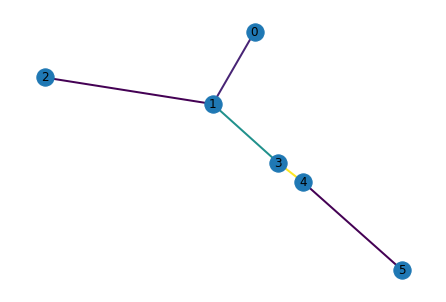

In [35]:
nx.draw(mstree[9], edge_color=d, width=2, with_labels=True)

In [36]:
edge_dia = {}
count = 0
for i,j in links:
    edge_dia[i,j]=d[count]
    count = count+1
edge_dia

{(0, 1): 0.06, (1, 2): 0.05, (1, 3): 0.1, (3, 4): 0.15, (4, 5): 0.05}

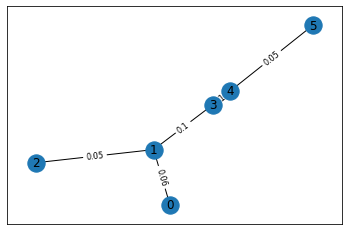

In [37]:
pos = nx.spring_layout(mstree[9])

nx.draw_networkx(mstree[9], pos)

nx.draw_networkx_edge_labels(mstree[9], pos, edge_labels=edge_dia,label_pos=0.5, font_size=8)

plt.show()